<a href="https://colab.research.google.com/github/bourama1/SMAP/blob/main/SMAP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMAP Project

## Installation and import

In [38]:
%pip install -q tfds-nightly tensorflow matplotlib

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Load and visualize the dataset

tfds.core.DatasetInfo(
    name='places365_small',
    full_name='places365_small/2.1.0',
    description="""
    The Places365-Standard dataset contains 1.8 million train images from 365 scene
    categories, which are used to train the Places365 CNNs. There are 50 images per
    category in the validation set and 900 images per category in the testing set.
    """,
    homepage='http://places2.csail.mit.edu/',
    data_dir='/root/tensorflow_datasets/places365_small/2.1.0',
    file_format=tfrecord,
    download_size=29.27 GiB,
    dataset_size=27.85 GiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(256, 256, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=365),
    }),
    supervised_keys=('image', 'label', 'filename'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=328500, num_shards=64>,
        'train': <SplitInfo num_examples=1803460, num_shards=256>,

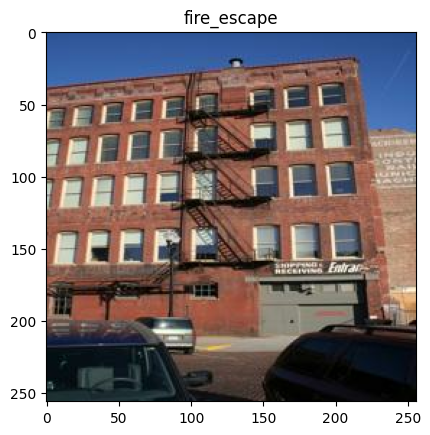

In [40]:
# Load the dataset
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'places365_small',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Display the image, label, and filename
get_label_name = metadata.features['label'].int2str
image, label, _ = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

# Display info rmation about the dataset
print(metadata)

## Preprocess dataset - Data augmentation

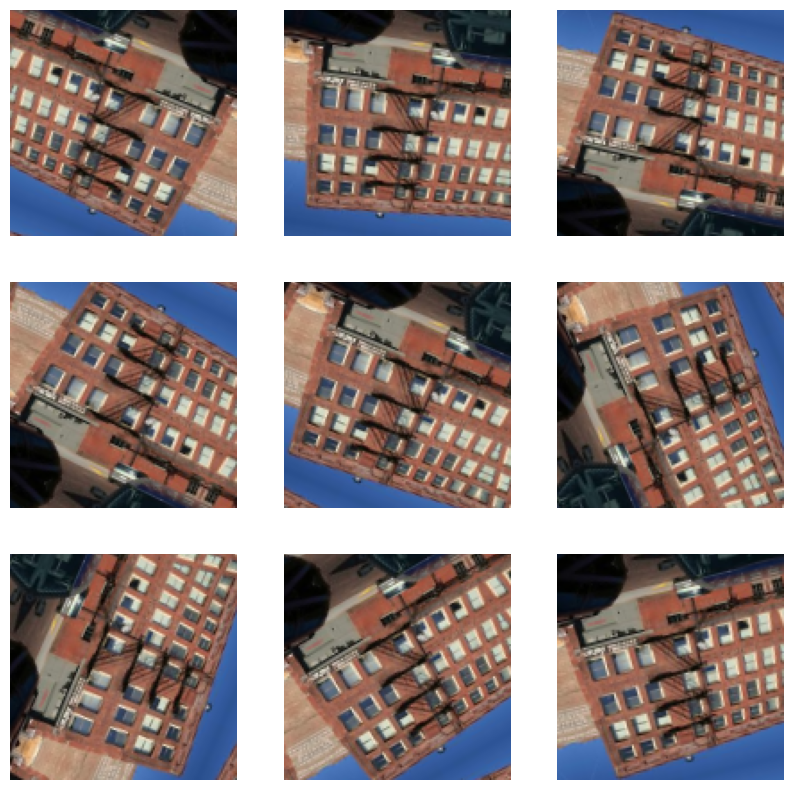

In [41]:
from tensorflow.keras import layers

IMG_SIZE = 127

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

image = resize_and_rescale(image)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [42]:
aug_ds = train_ds.map(
  lambda x, y, _: (resize_and_rescale(x, training=True), y))

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y, _: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

## Create Model

In [43]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.layers import Input

resnet_model = ResNet50(weights='imagenet',include_top=True)
resnet_model.layers.pop()
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [44]:
model_resnet50 = Sequential()

model_resnet50.add(Dense(3, input_shape=(224,224,3),activation='relu'))

model_resnet50.add(resnet_model)

model_resnet50.add(Dense(2, activation='softmax'))

model_resnet50.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model_resnet50.summary()

# Save the best weigth during training

filepath="weights_best.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_weights_only=True, mode='max')

callbacks_list = [checkpoint]

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 224, 224, 3)       12        
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_3 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 25638726 (97.80 MB)
Trainable params: 25585606 (97.60 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________
